# Field population statistical analyses -- Choice Experiment

this script conducts the statistics for the Choice experiment intake target of field caught Australian plauge locusts

Specifics for the experiment design can be found in the publication.


In [1]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("mgcv", "MuMIn", "multcomp", "gratia", 
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","tidyverse")

load_packages(packages)

i_am('README.md')

# Functions
                   
## Standard error
std <- function(x) sd(x)/sqrt(length(x))


# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10)


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser



Attaching package: ‘patchwork’


The following object is masked from ‘package:MASS’:

    area



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


here() starts at /home/datascience/herbivore_nutrient_interactions

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks gratia::boundary()
✖ dplyr::collapse()   masks nlme::collapse()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()  

# Choice Experiment 

## Data import

This code reads a CSV file containing IT data, cleans the column names, converts specific columns to factors, and removes rows with missing values in the `protein_consumed_g` and `carb_consumed_g` columns.

column descriptions:

- population: a factor with two levels Guntawang or Mendooran
- cage_no: the cage number for the specific locust used in the experiment
- diet_pair: a factor with two levels A or B: 7p:35c & 28p:14c or 7p:35c & 35p:7c *check if this is correct*
- sex: a factor with two levels M or F: Male or Female sex of the individual locust
- initial_mass_g: the starting mass for the specific locust in grams
- total_consumed_g: total amount of diet consumed between the two options for each individual
- protein_consumed_g: total amount of protein consumed for each individual
- carb_consumed_g: total amount of carbohydrates consumed for each individual



In [2]:

dat <- read_csv(here("data/raw/field_populations/IT_dat.csv"),show_col_types = FALSE) |>
    clean_names() |>
    mutate(across(c(population,sex,diet_pair,cage_no,low_p_diet,high_p_diet,notes_exclude_reason),~factor(.))) |>
    drop_na(protein_consumed_g,carb_consumed_g)
           

dat |> head()

cage_no,population,diet_pair,sex,initial_mass_g,low_p_diet,high_p_diet,total_consumed_g,protein_consumed_g,carb_consumed_g,notes_exclude_reason
<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,Mendooran,A,M,0.146,7p:35c,35p:7c,0.063,0.006,0.021,NA
2,Mendooran,A,M,0.150,7p:35c,35p:7c,0.069,0.010,0.019,NA
3,Mendooran,A,F,0.310,7p:35c,35p:7c,0.075,0.018,0.014,NA
4,Mendooran,A,F,0.201,7p:35c,35p:7c,0.063,0.004,0.022,NA
5,Mendooran,A,M,0.133,7p:35c,35p:7c,0.072,0.011,0.019,NA
6,Mendooran,A,F,0.279,7p:35c,35p:7c,0.129,0.013,0.042,NA


# Raw data visualization

I am using `ggpairs` to make this section pithy

In [3]:
numeric_columns <- c("initial_mass_g", "total_consumed_g", "protein_consumed_g","carb_consumed_g")

my_dens <- function(data, mapping,...) {
  ggplot(data = data, mapping=mapping) +
    geom_density(..., alpha = 0.7, fill = NA) 
}


population_raw_graph <- dat |>
    dplyr::select(!c(cage_no,notes_exclude_reason)) |>
    ggpairs(aes(color=population,fill=population),columns = numeric_columns,diag = list(continuous = my_dens))  +
    scale_colour_manual(values=c('#e5a335','#96410e'))  +
    scale_fill_manual(values=c('#e5a335','#96410e')) +
    theme_pubr()

sex_raw_graph <- dat |>
    dplyr::select(!c(cage_no,notes_exclude_reason)) |>
    ggpairs(aes(color=sex),columns = numeric_columns,diag = list(continuous = my_dens))  +
    scale_colour_manual(values=c('#e5a335','#96410e'))  +
    scale_fill_manual(values=c('#e5a335','#96410e')) +
    theme_pubr()

diet_pair_raw_graph <- dat |>
    dplyr::select(!c(cage_no,notes_exclude_reason)) |>
    ggpairs(aes(color=diet_pair),columns = numeric_columns,diag = list(continuous = my_dens))  +
    scale_colour_manual(values=c('#e5a335','#96410e'))  +
    scale_fill_manual(values=c('#e5a335','#96410e')) +
    theme_pubr()


Now save to the output location

In [5]:
# Define the output directory
output_dir <- here('output/field_populations/raw_visualization/')

# List of plots and their corresponding file names
plots <- list(
  "choice_experiment_population_raw_graph" = population_raw_graph,
  "choice_experiment_sex_raw_graph" = sex_raw_graph,
  "choice_experiment_diet_pair_raw_graph" = diet_pair_raw_graph
)

# Loop through each plot and save it
for (name in names(plots)) {
  ggsave(
    filename = file.path(output_dir, paste0(name, ".png")),
    plot = plots[[name]],
    width = 10, height = 10, dpi = 300
  )
}

## Model building
### General Additive Models (GAM) for Carbohydrate and Protein Consumption of Field Populations

In this analysis, we are exploring the relationship between carbohydrate and protein consumption using General Additive Models (GAMs) with different explanatory variables for two field popualtions of locusts. Each model assumes a multivariate normal (MVN) distribution for the responses.

### Model Overview

**Model 1: Non-linear Relationship with Initial Mass**

Formula:
- carb_consumed_g ~ population + diet_pair + sex + s(initial_mass_g, k=30)
- protein_consumed_g ~ population + diet_pair + sex + s(initial_mass_g, k=30)

Description: This model allows for a non-linear relationship between the initial mass of the subject and the consumption of carbohydrates and proteins. The smoothing function s(initial_mass_g, k=30) captures the non-linear effects with a basis dimension of 30.

**Model 2: Linear Relationship with Initial Mass**

Formula:
- carb_consumed_g ~ population + diet_pair + sex + initial_mass_g
- protein_consumed_g ~ population + diet_pair + sex + initial_mass_g

Description: In this model, the relationship between initial mass and nutrient consumption is assumed to be linear. This model tests whether a simpler, linear approximation can adequately describe the relationship.

**Model 3: Excluding Initial Mass**

Formula:
- carb_consumed_g ~ population + sex + diet_pair
- protein_consumed_g ~ population + sex + diet_pair

Description: This model excludes the initial mass as an explanatory variable, focusing only on population, sex, and diet pair to explain the variation in carbohydrate and protein consumption.

**Model 4: Null Model**

Formula:
- carb_consumed_g ~ 1
- protein_consumed_g ~ 1

Description: The null model includes only an intercept, serving as a baseline to compare the other models. This model should represent the worst fit to the data, as it assumes no relationship between the predictors and the response variables.

After fitting these models, we will compare them using the following criteria:

- Akaike Information Criterion (AIC): A measure of the relative quality of the models for a given dataset, considering both goodness of fit and model complexity.
- Bayesian Information Criterion (BIC): Similar to AIC, but with a stronger penalty for models with more parameters.
- Corrected AIC (AICc): AIC adjusted for small sample sizes, ensuring a more reliable comparison when sample sizes are limited.
By examining the AIC, BIC, and AICc values, we will select the best model for explaining carbohydrate and protein consumption.

In [6]:
# Model 1: Non-linear Relationship with Initial Mass
mod1 <- gam(list(
  carb_consumed_g ~ population + diet_pair + sex + s(initial_mass_g, k=30),
  protein_consumed_g ~ population + diet_pair + sex + s(initial_mass_g, k=30)
), family = mvn(d = 2), select = TRUE, data = dat)

# Model 2: Linear Relationship with Initial Mass
mod2 <- gam(list(
  carb_consumed_g ~ population + diet_pair + sex + initial_mass_g,
  protein_consumed_g ~ population + diet_pair + sex + initial_mass_g
), family = mvn(d = 2), select = TRUE, data = dat)

# Model 3: Excluding Initial Mass
mod3 <- gam(list(
  carb_consumed_g ~ population + diet_pair + sex,
  protein_consumed_g ~ population + diet_pair + sex
), family = mvn(d = 2), select = TRUE, data = dat)

# Model 4: NULL model (This should be the worst model)
mod4 <- gam(list(
  carb_consumed_g ~ 1,
  protein_consumed_g ~ 1
), family = mvn(d = 2), select = TRUE, data = dat)


## Model Diagnostics

To see how well these models fit, I will run `mgcv::gam.check()` on it


Method: REML   Optimizer: outer newton
full convergence after 17 iterations.
Gradient range [-0.0004276099,-1.37031e-05]
(score -576.2551 & scale 1).
Hessian positive definite, eigenvalue range [0.000199142,0.04150658].
Model rank =  69 / 69 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value
s(initial_mass_g)   2.90e+01 1.32e-04    0.94    0.27
s.1(initial_mass_g) 2.90e+01 9.29e-04    0.94    0.26


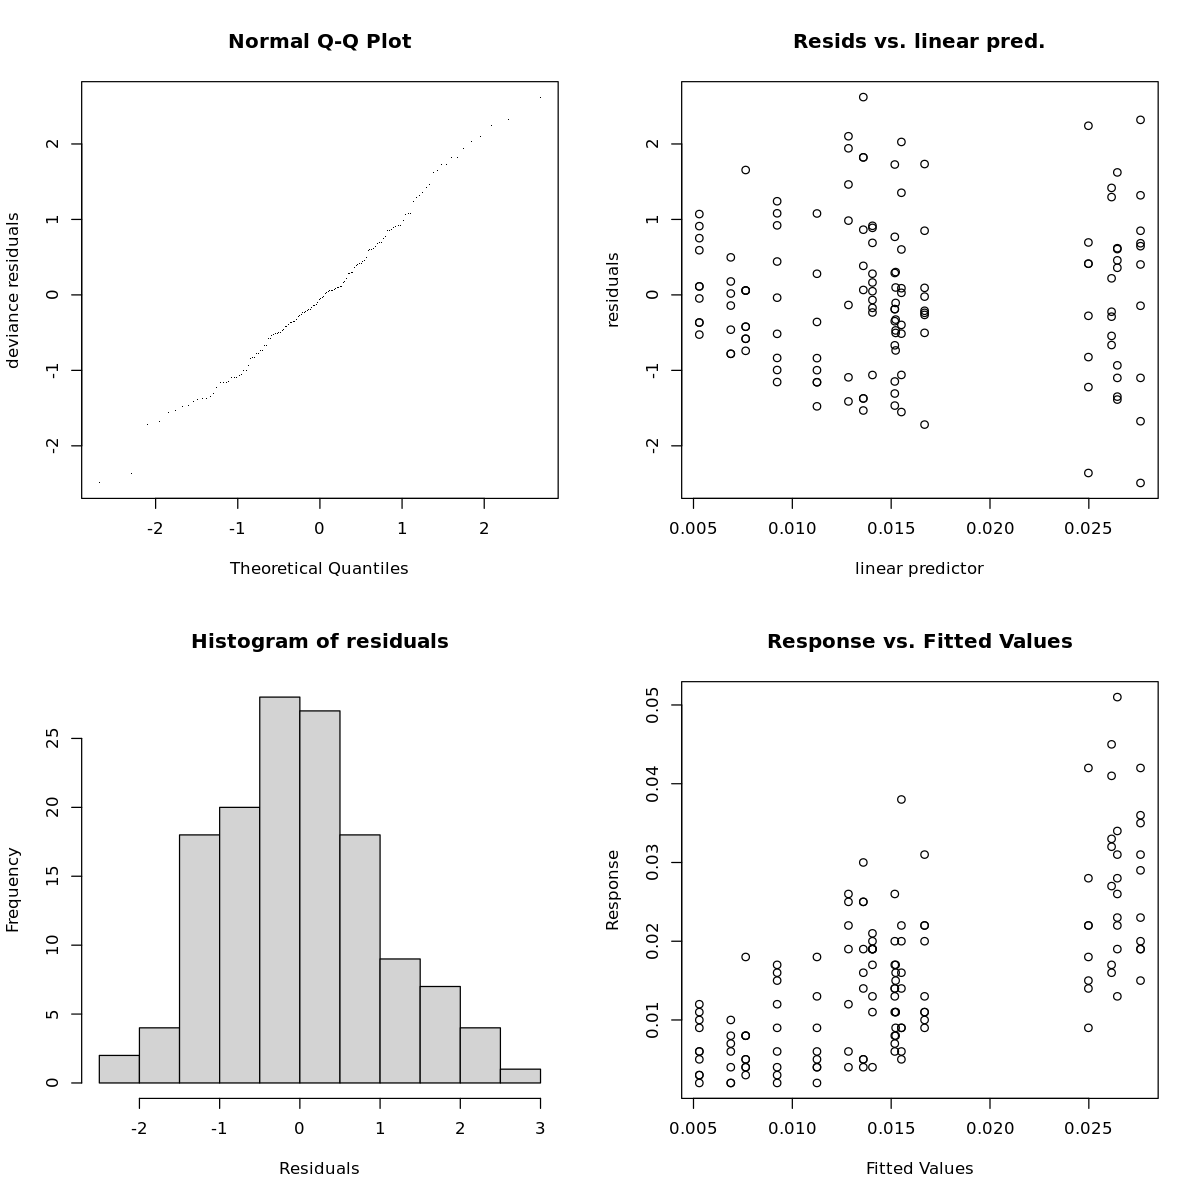

In [7]:
gam.check(mod1)

These diagnostic plots indicate these models are pretty well fit.

there is some discernable relationship in the variance plot, but it could be worse



## Model selection
now lets calculate the model selection criteria



In [8]:
# Model selection using AIC, BIC, and AICc
bic <- BIC(mod1, mod2, mod3, mod4) |>  # Bayesian Information Criterion
    mutate(deltaBIC = BIC - min(BIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model,BIC,deltaBIC)

aic <- AIC(mod1, mod2, mod3, mod4)  |>  # Akaike Information Criterion
    mutate(deltaAIC = AIC - min(AIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model,AIC,deltaAIC)

aicc <- AICc(mod1, mod2, mod3, mod4)  |>  # AIC adjusted for small sample size
    mutate(deltaAICc = AICc - min(AICc)) |>
    rownames_to_column('model') |>
    dplyr::select(model,AICc,deltaAICc)

model_selection_tables <- bic |>
    left_join(aic,by='model') |>
    left_join(aicc,by='model') |>
    mutate(experiment = 'choice_experiment')

In [9]:
model_selection_tables |>
    arrange(deltaBIC) 

model,BIC,deltaBIC,AIC,deltaAIC,AICc,deltaAICc,experiment
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mod3,-1201.021,0.000000000,-1225.596,0.000000000,-1220.964,0.000000000,choice_experiment
mod1,-1201.012,0.008717714,-1225.592,0.003981564,-1220.958,0.005864869,choice_experiment
mod4,-1198.464,2.556440510,-1209.635,15.961079538,-1208.682,12.281881543,choice_experiment
mod2,-1193.742,7.279113033,-1222.785,2.810900024,-1216.167,4.797502894,choice_experiment


Model selection criteria supports that model 3 (which excludes starting mass) is the most parsimonous model

The model summary is below

In [10]:
summary(mod3)


Family: Multivariate normal 
Link function: 

Formula:
carb_consumed_g ~ population + diet_pair + sex
protein_consumed_g ~ population + diet_pair + sex

Parametric coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.026442   0.002062  12.825  < 2e-16 ***
populationMendooran   -0.001464   0.002086  -0.702    0.483    
diet_pairB             0.001173   0.002082   0.563    0.573    
sexM                  -0.010924   0.002076  -5.262 1.43e-07 ***
(Intercept).1          0.013591   0.001500   9.062  < 2e-16 ***
populationMendooran.1 -0.002345   0.001517  -1.546    0.122    
diet_pairB.1           0.001592   0.001514   1.051    0.293    
sexM.1                -0.005952   0.001510  -3.941 8.12e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Deviance explained = 19.5%
-REML = -576.26  Scale est. = 1         n = 69

## Key Findings

Carbohydrate Consumption: Significant negative effects are observed for sexM (p < 0.001). The other predictors, populationMendooran and diet_pairB, are not significant.

Protein Consumption: Significant negative effects are found for sexM (p < 0.001). The other predictors, populationMendooran.1 and diet_pairB.1, do not show significant effects.

Model Fit: The model explains 19.5% of the deviance. 

## Model outputs

I am going to get the estimated marginal means for `diet_pair`,`sex`, and `population`

I will add this as a column on the dataframe 

I will also write out to disk the model object


In [13]:
choice_exp_preds <- expand.grid(
  population = unique(dat$population),
  diet_pair = unique(dat$diet_pair),
  sex = unique(dat$sex)
)

# Predict carbohydrate consumption
choice_exp_preds$pred_carb <- predict(mod3, newdata = choice_exp_preds, type = "response")[, 1]

# Predict protein consumption
choice_exp_preds$pred_protein <- predict(mod3, newdata = choice_exp_preds, type = "response")[, 2]

choice_exp_preds

population,diet_pair,sex,pred_carb,pred_protein
<fct>,<fct>,<fct>,<dbl>,<dbl>
Mendooran,A,M,0.01405383,0.005294840
Guntawang,A,M,0.01551792,0.007639662
Mendooran,B,M,0.01522647,0.006886952
Guntawang,B,M,0.01669057,0.009231775
Mendooran,A,F,0.02497786,0.011246543
Guntawang,A,F,0.02644195,0.013591366
Mendooran,B,F,0.02615051,0.012838655
Guntawang,B,F,0.02761460,0.015183478


Saving the predictions and model object for later visualization

In [17]:
write.csv(choice_exp_preds,here('data/processed/field_populations/choice_experiment_predictions.csv'),row.names=FALSE)


write.csv(model_selection_tables, here("output/field_populations/choice_experiment_model_selection_criteria_results.csv"),row.names=FALSE)


# Combine the lists into a single list
models <- list('mod1'= mod1, 'mod2' = mod2, 'mod3'= mod3, 'mod4'= mod4)

# Save the combined list to an RDS file
saveRDS(models, here("output/field_populations/model_objects/choice_experiment_models.rds"))